<a href="https://colab.research.google.com/github/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim_LHCb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse $B_c^+ \to J/\psi \mu^+ \nu_\mu$ RapidSim MC which was generated inside LHCb detector acceptance

In this notebook, we study RapidSim MC which was generated with all particles falling inside the LHCb detector coverage. Instead of looking only at the MC-truth angles, we will also look at the `reconstructed` values - these represent what we would be able to measure in real-life LHCb data. Quite a few aspects of this notebook are similar to those in [Bc2JpsiMuNu_RapidSim.ipynb](https://github.com/donalrinho/Bc2JpsiMuNu/blob/main/Bc2JpsiMuNu_RapidSim.ipynb), where we looked at a generator-level sample of decays from RapidSim to study MC-truth variables.

In [3]:
#Install uproot for ROOT file loading
!pip install uproot
#We use the vector package to make 4-vectors and manipulate them to calculate the decay angles
!pip install vector

     |████████████████████████████████| 301 kB 5.1 MB/s 
     |████████████████████████████████| 155 kB 5.1 MB/s 


In [4]:
#Import some useful packages
import uproot
import vector
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#Path to RapidSim Bc -> J/psi mu nu file, with events generated inside the LHCb detector
drive_dir = "/content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files"
file_path = f"{drive_dir}/Bc2JpsiMuNu_RapidSim_LHCb"
print(f"Loading ROOT file {file_path}.root")
tree_name = "DecayTree"
events = uproot.open(f"{file_path}.root:{tree_name}")
events

Loading ROOT file /content/drive/MyDrive/Bc2JpsiMuNu_ROOT_files/Bc2JpsiMuNu_RapidSim_LHCb.root


<TTree 'DecayTree' (136 branches) at 0x7f6aee083dd0>

In [6]:
#Make pandas DataFrame
df = events.arrays(library="pd")

In [7]:
#Check how many events we have in our DataFrame (same as the number of events in the ROOT TTree)
len(df)

912284

Here we have close to 1 million events in our DataFrame. We actually generated 3 million in RapidSim, but only those events falling inside the LHCb detector acceptance are stored in the ROOT file.


## Calculating decay angles and $q^2$

In this notebook, we are going to calculate the true decay angles and $q^2$ like we did in an earlier notebook. But in addition, we also want to calculate these quantities using the information we would actually have available to us in a real data analysis. Because of the missing neutrino, we don't reconstruct the full 4-momentum of our $B_c^+$ particle, and we have to operate with estimates for this quantity.

Let's not worry about the reconstructed angles and $q^2$ for now. But we can still rewrite our angle and $q^2$ calculator functions a little, to anticipate that we want to be able to calculate either true or reconstructed quantities.

In [8]:
def calc_theta_Jpsi(df, var_type):
  """
  Calculate the decay angle theta_Jpsi.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the angle
    
    Returns:
      theta_Jpsi -- decay angle values as a numpy array, which can be added to user DataFrame as a new column
  """
  
  if(var_type=="true"):
    var_suff = "TRUE"
  else:
    var_suff = "RECO"

  #Muon from the J/psi with the same charge as the Bc
  Jpsi_Mu_vars = {"px": f"Jpsi_Mu0_PX_{var_suff}",
                  "py": f"Jpsi_Mu0_PY_{var_suff}",
                  "pz": f"Jpsi_Mu0_PZ_{var_suff}",
                  "e": f"Jpsi_Mu0_E_{var_suff}"}
  
  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX_{var_suff}",
               "py": f"Jpsi_PY_{var_suff}",
               "pz": f"Jpsi_PZ_{var_suff}",
               "e": f"Jpsi_E_{var_suff}"}
  
  #Bc
  var_suff_Bc = var_suff
  if(var_type=="reco"):
    var_suff_Bc = var_suff_Bc.lower() #lowercase to use our estimates for the Bc 4-momentum i.e. reco instead of RECO
  Bc_vars = {"px": f"Bc_PX_{var_suff_Bc}",
             "py": f"Bc_PY_{var_suff_Bc}",
             "pz": f"Bc_PZ_{var_suff_Bc}",
             "e": f"Bc_E_{var_suff_Bc}"}
  
  #4-vectors
  v_Jpsi_Mu = vector.obj(x=df[Jpsi_Mu_vars["px"]],
                         y=df[Jpsi_Mu_vars["py"]],
                         z=df[Jpsi_Mu_vars["pz"]],
                         t=df[Jpsi_Mu_vars["e"]])
  
  v_Jpsi = vector.obj(x=df[Jpsi_vars["px"]],
                      y=df[Jpsi_vars["py"]],
                      z=df[Jpsi_vars["pz"]],
                      t=df[Jpsi_vars["e"]])
  
  v_Bc = vector.obj(x=df[Bc_vars["px"]],
                    y=df[Bc_vars["py"]],
                    z=df[Bc_vars["pz"]],
                    t=df[Bc_vars["e"]])
  
  #Boost to Bc rest frame
  Bc_boost_vec = -(v_Bc.to_beta3())
  v_Jpsi_Mu = v_Jpsi_Mu.boost_beta3(Bc_boost_vec)
  v_Jpsi = v_Jpsi.boost_beta3(Bc_boost_vec)
  v_Bc = v_Bc.boost_beta3(Bc_boost_vec)

  #Boost to J/psi rest frame
  Jpsi_boost_vec = -(v_Jpsi.to_beta3())
  v_Jpsi_Mu = v_Jpsi_Mu.boost_beta3(Jpsi_boost_vec)
  v_Bc = v_Bc.boost_beta3(Jpsi_boost_vec)
  
  #3-vectors
  v3_Jpsi_Mu = v_Jpsi_Mu.to_beta3()
  v3_Bc = v_Bc.to_beta3()
  #Unit vectors
  v3_Jpsi_Mu = v3_Jpsi_Mu / v3_Jpsi_Mu.mag
  v3_Bc = v3_Bc / v3_Bc.mag

  #Angle
  theta_Jpsi = v3_Jpsi_Mu.deltaangle(-v3_Bc)

  return theta_Jpsi

In [9]:
#Calculate the true theta_Jpsi
df["theta_Jpsi_true"] = calc_theta_Jpsi(df, "true")
df["costheta_Jpsi_true"] = np.cos(df["theta_Jpsi_true"])

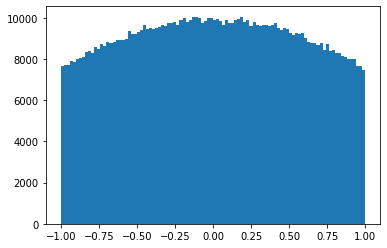

In [10]:
plt.hist(df["costheta_Jpsi_true"],bins=100)
plt.show();

In [11]:
def calc_theta_W(df, var_type):
  """
  Calculate the decay angle theta_W.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the angle
    
    Returns:
      theta_W -- decay angle values as a numpy array, which can be added to user DataFrame as a new column
  """

  if(var_type=="true"):
    var_suff = "TRUE"
  else:
    var_suff = "RECO"
  
  #Muon from the Bc decay
  Mu_vars = {"px": f"Mu_PX_{var_suff}",
             "py": f"Mu_PY_{var_suff}",
             "pz": f"Mu_PZ_{var_suff}",
             "e": f"Mu_E_{var_suff}"}
  
  #Muon from the J/psi with the same charge as the Bc
  Jpsi_Mu_vars = {"px": f"Jpsi_Mu0_PX_{var_suff}",
                  "py": f"Jpsi_Mu0_PY_{var_suff}",
                  "pz": f"Jpsi_Mu0_PZ_{var_suff}",
                  "e": f"Jpsi_Mu0_E_{var_suff}"}
  
  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX_{var_suff}",
               "py": f"Jpsi_PY_{var_suff}",
               "pz": f"Jpsi_PZ_{var_suff}",
               "e": f"Jpsi_E_{var_suff}"}
  
  #Bc
  var_suff_Bc = var_suff
  if(var_type=="reco"):
    var_suff_Bc = var_suff_Bc.lower() #lowercase to use our estimates for the Bc 4-momentum i.e. reco instead of RECO
  Bc_vars = {"px": f"Bc_PX_{var_suff_Bc}",
             "py": f"Bc_PY_{var_suff_Bc}",
             "pz": f"Bc_PZ_{var_suff_Bc}",
             "e": f"Bc_E_{var_suff_Bc}"}
  
  #4-vectors
  v_Mu = vector.obj(x=df[Mu_vars["px"]],
                    y=df[Mu_vars["py"]],
                    z=df[Mu_vars["pz"]],
                    t=df[Mu_vars["e"]])
  
  v_Jpsi = vector.obj(x=df[Jpsi_vars["px"]],
                      y=df[Jpsi_vars["py"]],
                      z=df[Jpsi_vars["pz"]],
                      t=df[Jpsi_vars["e"]])
  
  v_Bc = vector.obj(x=df[Bc_vars["px"]],
                    y=df[Bc_vars["py"]],
                    z=df[Bc_vars["pz"]],
                    t=df[Bc_vars["e"]])
  
  #W 4-vector = v_Bc - v_Jpsi
  v_W = v_Bc - v_Jpsi

  #Boost to Bc rest frame
  Bc_boost_vec = -(v_Bc.to_beta3())
  v_Mu = v_Mu.boost_beta3(Bc_boost_vec)
  v_W = v_W.boost_beta3(Bc_boost_vec)
  v_Bc = v_Bc.boost_beta3(Bc_boost_vec)

  #Boost to W rest frame
  W_boost_vec = -(v_W.to_beta3())
  v_Mu = v_Mu.boost_beta3(W_boost_vec)
  v_Bc = v_Bc.boost_beta3(W_boost_vec)
  
  #3-vectors
  v3_Mu = v_Mu.to_beta3()
  v3_Bc = v_Bc.to_beta3()
  #Unit vectors
  v3_Mu = v3_Mu / v3_Mu.mag
  v3_Bc = v3_Bc / v3_Bc.mag

  #Angle
  theta_W = v3_Mu.deltaangle(-v3_Bc)

  return theta_W

In [12]:
#Calculate the true theta_W
df["theta_W_true"] = calc_theta_W(df, "true")
df["costheta_W_true"] = np.cos(df["theta_W_true"])

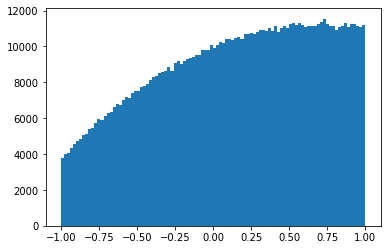

In [13]:
plt.hist(df["costheta_W_true"],bins=100)
plt.show();

In [14]:
def calc_chi(df, var_type):
  """
  Calculate the decay angle chi.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the angle
    
    Returns:
      chi -- decay angle values as a numpy array, which can be added to user DataFrame as a new column
  """

  if(var_type=="true"):
    var_suff = "TRUE"
  else:
    var_suff = "RECO"
  
  #Muon from the Bc decay
  Mu_vars = {"px": f"Mu_PX_{var_suff}",
             "py": f"Mu_PY_{var_suff}",
             "pz": f"Mu_PZ_{var_suff}",
             "e": f"Mu_E_{var_suff}"}
  
  #Muon from the J/psi with the same charge as the Bc
  Jpsi_Mu_vars = {"px": f"Jpsi_Mu0_PX_{var_suff}",
                  "py": f"Jpsi_Mu0_PY_{var_suff}",
                  "pz": f"Jpsi_Mu0_PZ_{var_suff}",
                  "e": f"Jpsi_Mu0_E_{var_suff}"}
  
  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX_{var_suff}",
               "py": f"Jpsi_PY_{var_suff}",
               "pz": f"Jpsi_PZ_{var_suff}",
               "e": f"Jpsi_E_{var_suff}"}
  
  #Bc
  var_suff_Bc = var_suff
  if(var_type=="reco"):
    var_suff_Bc = var_suff_Bc.lower() #lowercase to use our estimates for the Bc 4-momentum i.e. reco instead of RECO
  Bc_vars = {"px": f"Bc_PX_{var_suff_Bc}",
             "py": f"Bc_PY_{var_suff_Bc}",
             "pz": f"Bc_PZ_{var_suff_Bc}",
             "e": f"Bc_E_{var_suff_Bc}"}
  
  #4-vectors
  v_Mu = vector.obj(x=df[Mu_vars["px"]],
                    y=df[Mu_vars["py"]],
                    z=df[Mu_vars["pz"]],
                    t=df[Mu_vars["e"]])
  
  v_Jpsi_Mu = vector.obj(x=df[Jpsi_Mu_vars["px"]],
                         y=df[Jpsi_Mu_vars["py"]],
                         z=df[Jpsi_Mu_vars["pz"]],
                         t=df[Jpsi_Mu_vars["e"]])
  
  v_Jpsi = vector.obj(x=df[Jpsi_vars["px"]],
                      y=df[Jpsi_vars["py"]],
                      z=df[Jpsi_vars["pz"]],
                      t=df[Jpsi_vars["e"]])
  
  v_Bc = vector.obj(x=df[Bc_vars["px"]],
                    y=df[Bc_vars["py"]],
                    z=df[Bc_vars["pz"]],
                    t=df[Bc_vars["e"]])
  
  #W 4-vector = v_Bc - v_Jpsi
  v_W = v_Bc - v_Jpsi
  
  #Boost to Bc rest frame
  Bc_boost_vec = -(v_Bc.to_beta3())
  v_Mu = v_Mu.boost_beta3(Bc_boost_vec)
  v_Jpsi_Mu = v_Jpsi_Mu.boost_beta3(Bc_boost_vec)
  v_Jpsi = v_Jpsi.boost_beta3(Bc_boost_vec)
  v_W = v_W.boost_beta3(Bc_boost_vec)
  v_Bc = v_Bc.boost_beta3(Bc_boost_vec)

  v3_Jpsi = v_Jpsi.to_beta3()
  v3_Jpsi = v3_Jpsi / v3_Jpsi.mag

  v3_Jpsi_Mu = v_Jpsi_Mu.to_beta3()
  v3_Jpsi_Mu = v3_Jpsi_Mu / v3_Jpsi_Mu.mag

  v3_Jpsi_Jpsi_Mu = v3_Jpsi.cross(v3_Jpsi_Mu)

  v3_W = v_W.to_beta3()
  v3_W = v3_W / v3_W.mag

  v3_Mu = v_Mu.to_beta3()
  v3_Mu = v3_Mu / v3_Mu.mag

  v3_W_Mu = v3_W.cross(v3_Mu)

  v3_x = v3_Jpsi_Jpsi_Mu / v3_Jpsi_Jpsi_Mu.mag
  v3_z = v3_Jpsi
  v3_y = v3_z.cross(v3_x)
  v3_y = v3_y / v3_y.mag

  C = v3_W_Mu.dot(v3_x)
  S = v3_W_Mu.dot(v3_y)

  chi = np.arctan2(C,S)

  return chi

In [15]:
#Calculate the true chi
df["chi_true"] = calc_chi(df, "true")

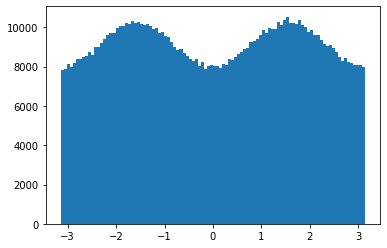

In [16]:
plt.hist(df["chi_true"],bins=100)
plt.show();

In [17]:
def calc_q2(df, var_type):
  """
  Calculate the decay angle chi.

    Parameters:
      df -- input DataFrame (must containin the TRUE PX, PY, PZ, E values for each particle)
      var_type -- whether to calculate true or reconstructed value of the q2
    
    Returns:
      q2 -- momentum transfer as a numpy array, which can be added to user DataFrame as a new column
  """

  if(var_type=="true"):
    var_suff = "TRUE"
  else:
    var_suff = "RECO"

  #J/psi
  Jpsi_vars = {"px": f"Jpsi_PX_{var_suff}",
               "py": f"Jpsi_PY_{var_suff}",
               "pz": f"Jpsi_PZ_{var_suff}",
               "e": f"Jpsi_E_{var_suff}"}
  
  #Bc
  var_suff_Bc = var_suff
  if(var_type=="reco"):
    var_suff_Bc = var_suff_Bc.lower() #lowercase to use our estimates for the Bc 4-momentum i.e. reco instead of RECO
  Bc_vars = {"px": f"Bc_PX_{var_suff_Bc}",
             "py": f"Bc_PY_{var_suff_Bc}",
             "pz": f"Bc_PZ_{var_suff_Bc}",
             "e": f"Bc_E_{var_suff_Bc}"}

  v_Jpsi = vector.array({
      "px": df[Jpsi_vars["px"]],
      "py": df[Jpsi_vars["py"]],
      "pz": df[Jpsi_vars["pz"]],
      "E": df[Jpsi_vars["e"]]})

  v_Bc = vector.array({
      "px": df[Bc_vars["px"]],
      "py": df[Bc_vars["py"]],
      "pz": df[Bc_vars["pz"]],
      "E": df[Bc_vars["e"]]})

  v_q = v_Bc - v_Jpsi
  q2 = v_q.mass2
  
  return q2

In [18]:
#Add true q2 to our DataFrame
df["q2_true"] = calc_q2(df, "true")

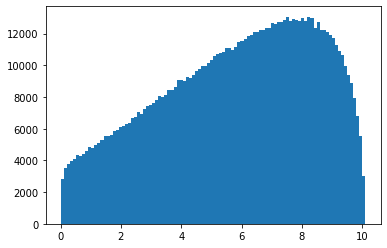

In [19]:
plt.hist(df["q2_true"],bins=100)
plt.show();

## Dealing with reconstructed quantities rather than true

So far we have just recalculated the true angles and $q^2$ like in our first notebook. But we tell our functions, based on passing `true` as an argument, to use the variables with `_TRUE` in their name to do the calculations. 

To calculate the reconstructed quantities, we need to point our functions at reconstructed values of the particle momenta. In our ROOT, file, these variables have names for a particle `X`:
 - `X_PX`
 - `X_PY`
 - `X_PZ`
 - `X_E`

Let's rename them to have `_RECO` in their name, to make the distinction between `_TRUE` and `_RECO` clearer.
 

In [20]:
#Rename the reconstructed momenta to have _RECO in their name
for particle in ["Bc","Jpsi","Jpsi_Mu0","Jpsi_Mu1","Mu"]:
  for var in ["PX","PY","PZ","E"]:
    #Rename the branch to have _RECO in the name
    df[f"{particle}_{var}_RECO"] = df[f"{particle}_{var}"]
    #Drop the original column name
    df = df.drop(columns=[f"{particle}_{var}"])

In [21]:
#Check we have the right names
all_vars = df.columns
for x in all_vars:
  if("_RECO" in x):
    print(x)

Bc_PX_RECO
Bc_PY_RECO
Bc_PZ_RECO
Bc_E_RECO
Jpsi_PX_RECO
Jpsi_PY_RECO
Jpsi_PZ_RECO
Jpsi_E_RECO
Jpsi_Mu0_PX_RECO
Jpsi_Mu0_PY_RECO
Jpsi_Mu0_PZ_RECO
Jpsi_Mu0_E_RECO
Jpsi_Mu1_PX_RECO
Jpsi_Mu1_PY_RECO
Jpsi_Mu1_PZ_RECO
Jpsi_Mu1_E_RECO
Mu_PX_RECO
Mu_PY_RECO
Mu_PZ_RECO
Mu_E_RECO


Before we move on to calculating reconstructed angles and $q^2$, we should note that the `Bc` kinematic variables here are quite far in value from the true `Bc` kinematics. This is because these variables do not include the missing neutrino, and so highly underestimate the true 4-momentum of the $B_c^+$. We want to try and improve our estimates for the reconstructed $B_c^+$ momentum, so that we can use those values in our angle and $q^2$ calculations.

The first thing we can do is estimate the z component of the $B_c^+$ momentum using the expression $p(B_c^+)_z = \frac{m_{B_c}}{m^{reco}} \times p_z^{reco}$, where $m_{B_c} = 6.27447$ GeV (see [here](https://pdglive.lbl.gov/Particle.action?init=0&node=S091&home=MXXX049)) is the measured $B_c^+$ meson mass, $m^{reco}$ is the mass we reconstruct in the absence of the neutrino ($m^{reco} = m(J/\psi \mu^+)$), and $p_z^{reco}$ is the z component of the momentum we reconstruct. Let's calculate this in our DataFrame:

In [22]:
m_Bc = 6.27447
df["Bc_PZ_reco"] = (m_Bc / df["Bc_M"]) * df["Bc_PZ_RECO"]

Here, we use `_reco` to differentiate our new estimated $B_c^+$ z-momentum from the measured z-momentum which has `_RECO` in the name. The measured z-momentum is simply the z-momentum of the $J/\psi \mu^+$ system.

The next thing we can do is estimate the total $B_c^+$ momentum from our $p(B_c^+)_z$ estimate. To do this, we exploit the relation $|p(B_c^+)| = p(B_c^+)_z \times \sqrt{1 + tan^2({\alpha})}$. Here, $\alpha$ is the angle between the z-axis and the flight direction of our $B_c^+$. We can determine the flight direction of the $B_c^+$ using two points in 3D space:
 - The primary vertex (PV), which is the point where the proton-proton collision occurs. This is where the $B_c^+$ is initially created. 
 - The decay vertex (DV), which is the point where the $B_c^+$ decays to a $J/\psi$, a muon, and a neutrino. The $J/\psi$ also immediately decays to two muons, so we have a well-measured point in space where three muons originate. This enables the LHCb detector to reconsruct the DV.

The flight direction of the $B_c^+$ is given by the vector joining the PV and DV.

In our DataFrame, we have values for the flight distance of the $B_c^+$ along the x, y, and z directions. These are:
 - `BC_FD_x`
 - `Bc_FD_y`
 - `Bc_FD_z`

We can use these to create a flight vector for the $B_c^+$, and calculate the angle $\alpha$ it makes to the z-axis. Because the three-muon vertex and primary vertex should be very well reconstructed at LHCb, we can use the `_TRUE` versions of these flight distances, which assumes that the PV and DV have no measurement uncertainties.

In [23]:
def calc_alpha(df, var_type):
  """
  Calculate the angle between the Bc flight vector and the z-axis
    
    Parameters:
      df -- input DataFrame
      var_type -- whether to calculate true or reconstructed value of the q2
    
    Returns:
      alpha -- angle between the Bc flight vector and the z-axis
  """

  if(var_type=="true"):
    var_suff = "_TRUE"
  else:
    var_suff = ""

  Bc_vars = {"FD_x": f"Bc_FD_x{var_suff}",
             "FD_y": f"Bc_FD_y{var_suff}",
             "FD_z": f"Bc_FD_z{var_suff}"}
  
  #Flight vector
  v_FD = vector.obj(x=df[Bc_vars["FD_x"]], 
                    y=df[Bc_vars["FD_y"]], 
                    z=df[Bc_vars["FD_z"]])
  #Unit vector
  v_FD = v_FD / v_FD.mag
  
  #z-axis vector
  v_z = vector.obj(x=0., 
                   y=0., 
                   z=1.)
  #Unit vector
  v_z = v_z / v_z.mag

  #Angle between Bc flight and the z-axis
  alpha = v_FD.deltaangle(v_z)

  return alpha

In [24]:
#Calculate alpha angle for each Bc in our DataFrame, using the true flight vectors
df["Bc_alpha"] = calc_alpha(df, "true")

In [25]:
#Calculate the magnitude of the total B momentum, given our angle alpha and estimate for the z momentum
df["Bc_P_reco"] = df["Bc_PZ_reco"] * np.sqrt(1. + np.tan(df["Bc_alpha"])**2)

Now we have an estimate for the magnitude of the total $B_c^+$ momentum. We can split this into x, y, and z components by again using our $B_c^+$ flight vector.

The total flight of the $B_c^+$ is $f(B_c^+) = \sqrt{f(B_c^+)_x^2 + f(B_c^+)_y^2 + f(B_c^+)_z^2}$. The component of the momentum in the x-direction is then $p(B_c^+)_x = |p(B_c^+)| \times \frac{f(B_c^+)_x}{f(B_c^+)}$. Here, we are projecting the total momentum of the $B_c^+$ onto the x-axis, using the x-component of the $B_c^+$ flight vector. This works because the direction we measure the $B_c^+$ to travel in should align with its momentum direction.

In [26]:
df["Bc_FD_TRUE"] = np.sqrt(df["Bc_FD_x_TRUE"]**2 + df["Bc_FD_y_TRUE"]**2 + df["Bc_FD_z_TRUE"]**2)
df["Bc_PX_reco"] = df["Bc_P_reco"] * (df["Bc_FD_x_TRUE"] / df["Bc_FD_TRUE"])
df["Bc_PY_reco"] = df["Bc_P_reco"] * (df["Bc_FD_y_TRUE"] / df["Bc_FD_TRUE"])
df["Bc_PZ_reco"] = df["Bc_P_reco"] * (df["Bc_FD_z_TRUE"] / df["Bc_FD_TRUE"])

Now we have our 3-momentum component estimates for the $B_c^+$. The last step is to calculate the energy of the $B_c^+$, the final component of our 4-vector. In the above procedure, we have actually assumed that our $B_c^+$ has the mass of the $B_c^+$ meson - we are using this as a fixed constraint in our system. So to calculate the energy, we have $E(B_c^+) = \sqrt{m(B_c^+)^2 + |p(B_c^+)|^2}$, where $m(B_c^+) = 6.27447$ GeV as above, and $|p(B_c^+)|$ is our estimate for the $B_c^+$ total momentum magnitude. 

In [27]:
df["Bc_E_reco"] = np.sqrt(m_Bc**2 + df["Bc_P_reco"]**2)

## Calculating the reconstructed decay angles and $q^2$, and comparing them to the their true counterparts

Armed with our new estimate for the $B_c^+$ 4-momentum, we can now calculate reconstructed values for the decay angles and the $q^2$. You should carefully study the functions we use to calculate the angles and $q^2$ above, and how we have adjusted them since our previous notebook to handle reconsructed calculations. In particular, notice that we are using `_reco` variables for the $B_c^+$ (as we have just calculated), and `_RECO` values for the other particles as they are measured in LHCb.

In [28]:
df["theta_Jpsi_reco"] = calc_theta_Jpsi(df, "reco")
df["costheta_Jpsi_reco"] = np.cos(df["theta_Jpsi_reco"])

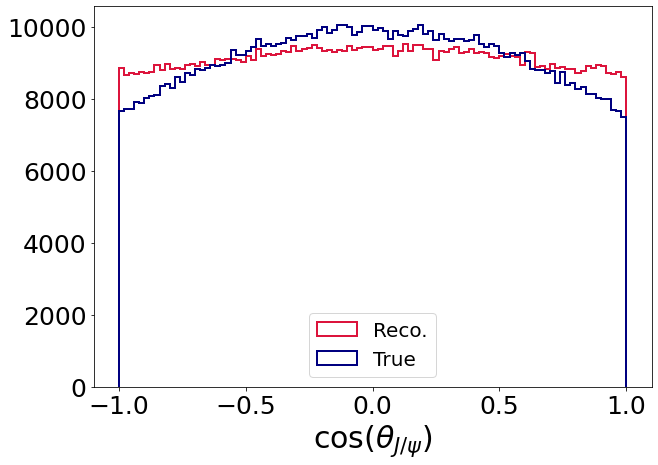

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(df["costheta_Jpsi_reco"], bins=100, color="crimson", histtype="step", linewidth=2, label="Reco.")
plt.hist(df["costheta_Jpsi_true"], bins=100, color="navy", histtype="step", linewidth=2, label="True")
plt.xlabel("$\cos(\\theta_{J/\psi})$",fontsize=30)
ax.tick_params(axis='both', which='both', labelsize=25)
plt.legend(fontsize=20,loc="lower center")
plt.show();

Here we can see both the true decay angle and the reconstructed version. Because of the missing neutrino, which means we have to estimate the $B_c^+$ 4-momentum, and the fact that the muons we reconsruct are not perfectly measured, the reconstructed angle is smeared out compared to the true angle. 

Another way to visualise this is by plotting the difference between the true and reconstructed angles. This is known as the **resolution**.

In [30]:
df["costheta_Jpsi_res"] = df["costheta_Jpsi_reco"] - df["costheta_Jpsi_true"]

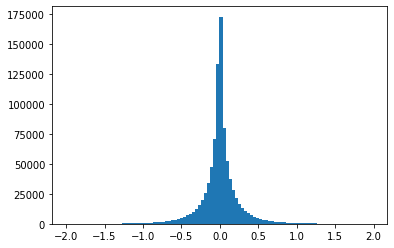

In [31]:
plt.hist(df["costheta_Jpsi_res"], bins=100)
plt.show();

Let's calculate the other angles and $q^2$.

In [32]:
df["theta_W_reco"] = calc_theta_W(df, "reco")
df["costheta_W_reco"] = np.cos(df["theta_W_reco"])

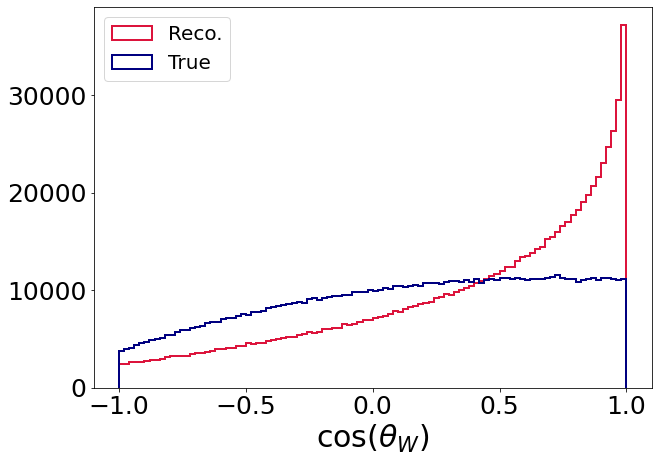

In [33]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(df["costheta_W_reco"], bins=100, color="crimson", histtype="step", linewidth=2, label="Reco.")
plt.hist(df["costheta_W_true"], bins=100, color="navy", histtype="step", linewidth=2, label="True")
plt.xlabel("$\cos(\\theta_W)$",fontsize=30)
ax.tick_params(axis='both', which='both', labelsize=25)
plt.legend(fontsize=20,loc="upper left")
plt.show();

In [34]:
df["costheta_W_res"] = df["costheta_W_reco"] - df["costheta_W_true"]

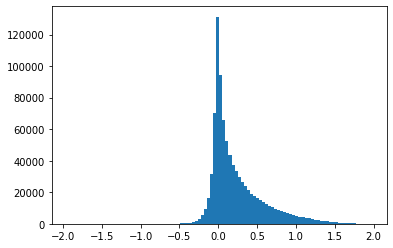

In [35]:
plt.hist(df["costheta_W_res"], bins=100)
plt.show();

In [36]:
df["chi_reco"] = calc_chi(df, "reco")

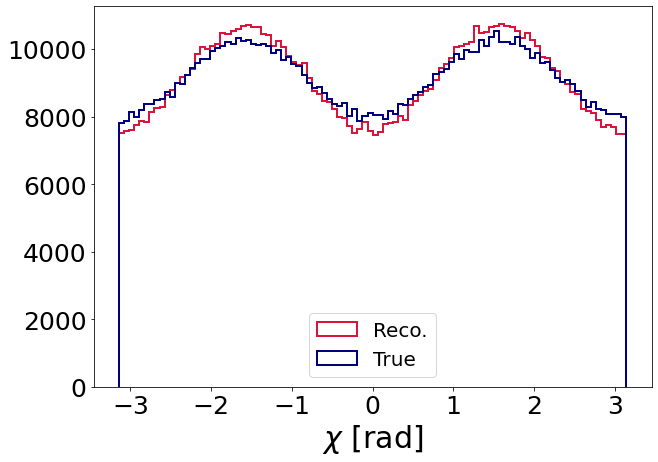

In [37]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(df["chi_reco"], bins=100, color="crimson", histtype="step", linewidth=2, label="Reco.")
plt.hist(df["chi_true"], bins=100, color="navy", histtype="step", linewidth=2, label="True")
plt.xlabel("$\\chi$ [rad]",fontsize=30)
ax.tick_params(axis='both', which='both', labelsize=25)
plt.legend(fontsize=20,loc="lower center")
plt.show();

In [38]:
df["chi_res"] = df["chi_reco"] - df["chi_true"]

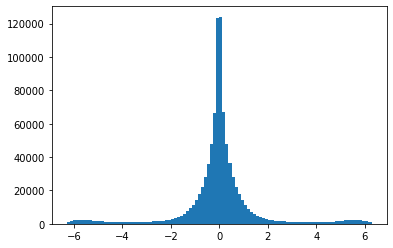

In [39]:
plt.hist(df["chi_res"], bins=100)
plt.show();

In [40]:
df["q2_reco"] = calc_q2(df, "reco")

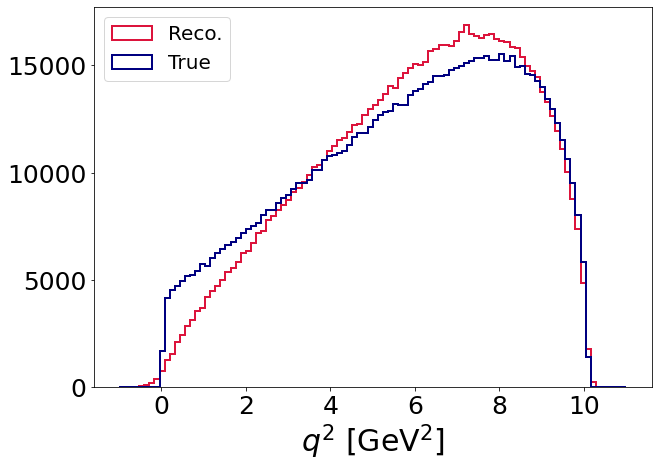

In [41]:
fig, ax = plt.subplots(figsize=(10,7))
plt.hist(df["q2_reco"], bins=100, range=(-1,11), color="crimson", histtype="step", linewidth=2, label="Reco.")
plt.hist(df["q2_true"], bins=100, range=(-1,11), color="navy", histtype="step", linewidth=2, label="True")
plt.xlabel("$q^2$ [GeV$^2$]",fontsize=30)
ax.tick_params(axis='both', which='both', labelsize=25)
plt.legend(fontsize=20,loc="upper left")
plt.show();

In [42]:
df["q2_res"] = df["q2_reco"] - df["q2_true"]

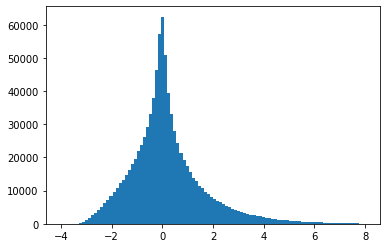

In [43]:
plt.hist(df["q2_res"], bins=100, range=(-4,8))
plt.show();

Now we have reconsructed values for the decay angles and $q^2$, and compared them to the truth-level versions. The reconstructed variables resemble what we might expect to measure in real LHCb data. 

Because the reconstructed decay angles differ in shape compared to the true angles, we cannot simply fit their distribution to measure the helicity ampltiudes (like we did with our truth-level RapidSim in a previous notebook). To measure the helicity amplitudes, we must take into account the resolution effects which alter the shapes of the decay angles. We will move onto this in our next notebook, but a primer can be found in [this paper](https://arxiv.org/abs/1908.04643).

In [44]:
#Save our ROOT file with the new variables for use in further analysis

#Make a new file in our Google Drive, with the same name as our input file but with _Vars added to the end
out_file_path = f"{file_path}_Vars"
outfile = uproot.recreate(f"{out_file_path}.root")

In [45]:
#Add our DataFrame to the file as a TTree with the same name as our input file TTree name
#This might take a little while to run as our DataFrame is quite big
outfile[tree_name] = df

In [46]:
#Close the file to finalise things
outfile.close()